In [1]:
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
from CaffeVPLUtils import *
from scipy.stats import f_oneway, ttest_ind,ttest_rel, kruskal, mannwhitneyu, ttest_1samp, norm
from scipy.interpolate import UnivariateSpline
from scipy import misc
import numpy as np
import os
import cPickle as pkl
import fnmatch
from scipy.stats import sem
results_dir = os.path.join('results', 'real2')
figs_dir = os.path.join('figs', 'real2')
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.display import SVG, display
import svgutils.compose as sg

import matplotlib.ticker
#matplotlib.ticker._mathdefault = lambda x: '\\mathdefault{%s}'%x
from matplotlib import rc
fig_dir = 'figs/'
panel_font = dict(fontsize=15, fontweight=3)
plt.rc('font',family='Times')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 15
plt.rcParams['legend.frameon'] = False
plt.rcParams['lines.marker'] = None
#plt.rc('text', usetex=True)
rc('mathtext', default='regular') 
plt.rcParams['axes.axisbelow']=True

C:\Anaconda64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# set display defaults
plt.rcParams['figure.figsize'] = (5, 5)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap
    
def load_df(res_names, s):
    
    files = get_results_files(s)
    results = dict()
    
    for this_file in files:
        
        with open(os.path.join(results_dir,this_file), 'r') as f:
            
            res = pkl.load(f)
            attrs = parse_filename(res['filename'])
            var_param_name = attrs['var_param_name']
            
            for pi, p in enumerate(res['params']):   
                # inserting results from file content
                for name in res_names:
                    results.setdefault(name, [])
                    # the following results have an extra dimension of var_param_name
                    if name in ['accs','losses','dps','n_accs','dws','n_dps']:
                        results[name].append(res[name][pi])
                    else:
                        results[name].append(res[name])
                # inserting results from file name
                for attr in attrs:
                    results.setdefault(attr, [])

                    results[attr].append(attrs[attr])
                
                # attributes that changes (var_param_name) should be corrected
                results.setdefault('start_layer', [])
                if var_param_name == 'layer':
                    results['start_layer'].append(p)
                else:
                    results[var_param_name][-1] = p
                    results['start_layer'].append(p)
    return pd.DataFrame(results)
    
def get_results_files(s):
    
    s = s.replace('[','?')
    s = s.replace(']','?')
    s = s.replace("'","?")
    s = s.replace(",","?")
    
    if '.pdf' in s:
        s = s[0:-18]
    elif '-' in s[-15:]:
        s = s[0:-15]
    
    s = '*' + s + '*'
    files = [os.path.join(f[0], f1) for f in os.walk(figs_dir) for f1 in f[2]]

    files = fnmatch.filter(files, s)
    files = [os.path.basename(f)[:-4]+'.results' for f in files]
    return files
                
def parse_filename(fn):
    
    file_attr = dict()
    attrs = fn.split('_')
    attrs = [s.translate(None, '[]') for s in attrs]

    if 'morph' not in fn:

        # merge d_angle
        if 'd' in attrs:
            d_idx = attrs.index('d')
            attrs[d_idx] += '_'+attrs[d_idx+1]
            del attrs[d_idx+1]
            
        file_attr['var_param_name'] = attrs[2]

        file_attr['network'] = attrs[5]
        file_attr['train_feat'] = attrs[1]
        file_attr['noise'] = float(attrs[5])
        file_attr['angle'] = float(attrs[6])
        file_attr['wave'] = float(attrs[7])
        file_attr['ctrst'] = float(attrs[8])

        file_attr['d_angle'] = float(attrs[9])
        file_attr['d_wave'] = float(attrs[10])
        
        file_attr['batch_size'] = int(attrs[11])
        file_attr['base_lr'] = float(attrs[12])
        file_attr['momentum'] = float(attrs[13])
        file_attr['weight_decay'] = float(attrs[14])
        file_attr['niter']  = int(attrs[16])
        file_attr['version']  = int(attrs[17])
    else:
        "A_morph_1_127_layer_[0.0,5.0,1.0]_20_0.2_20_0.0001_0_1000_6_03-29-10-52-45"
        file_attr['var_param_name'] = attrs[4]
        file_attr['level'] = int(attrs[2])
        file_attr['dset'] = int(attrs[3])
        file_attr['train_feat'] = 'face'
        file_attr['noise'] = float(attrs[6])
        file_attr['ctrst'] = float(attrs[7])
        
        file_attr['batch_size'] = int(attrs[8])
        file_attr['base_lr'] = float(attrs[9])
        
        #file_attr['momentum'] = float(attrs[10])
        #file_attr['weight_decay'] = float(attrs[11])
        
        file_attr['niter']  = int(attrs[11])
        file_attr['version']  = int(attrs[12])

    return file_attr



In [4]:
import numpy as np
from scipy import stats, linalg

def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """
    
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    P_pv   = np.zeros((p, p), dtype=np.float)
    P_res  = np.zeros((p, p, C.shape[0], 2))
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            this_C = np.c_[C[:, idx], np.ones((C.shape[0],1))]
            beta_i = linalg.lstsq(this_C, C[:, j])[0]
            beta_j = linalg.lstsq(this_C, C[:, i])[0]

            res_j = C[:, j] - this_C.dot( beta_i)
            res_i = C[:, i] - this_C.dot(beta_j)
            
            corr, pv = stats.pearsonr(res_i, res_j)
            P_corr[i, j], P_pv[i,j] = corr, pv
            P_corr[j, i], P_pv[j,i] = corr, pv
            P_res[i, j] = np.c_[res_i, res_j]
            P_res[j, i] = np.c_[res_j, res_i]

        
    return P_corr, P_pv, P_res

# Stumulus examples

In [5]:
sg.Figure("18cm", "10.2cm",
       sg.Panel(
          sg.SVG(fig_dir+'network_diagram.svg').move(10,0).scale(3.5),
          sg.Text("A", 15, 5, size=15, weight='bold').move(10,10),
          ),
       sg.Panel(
          sg.SVG(fig_dir+'face_examples_5.0_0.6.svg').move(-70,0).scale(0.95),
          sg.Text("B", 15, 0, size=15, weight='bold').move(10,-5),
          ).move(0, 200),
).save(fig_dir+"fig_1.svg")

display(SVG(fig_dir+'fig_1.svg'))

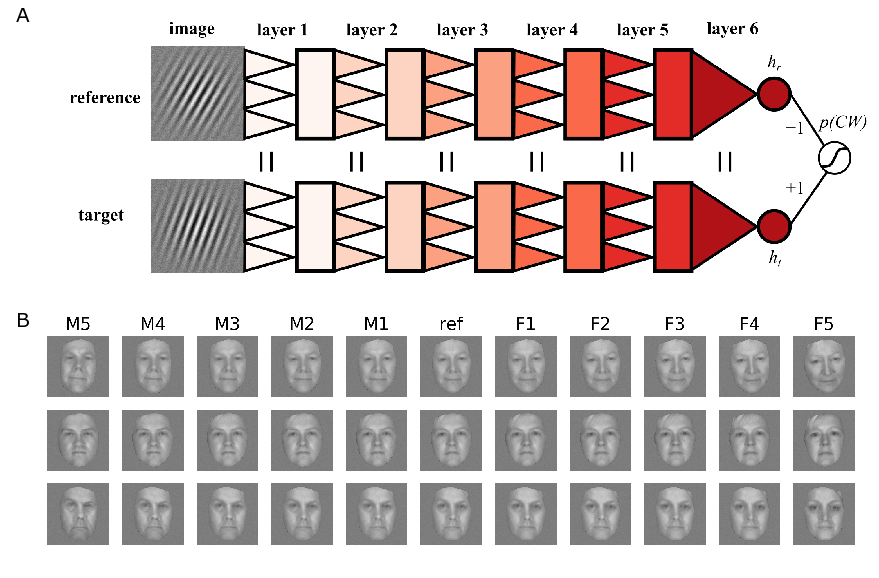

In [6]:
fig, axes = plt.subplots(2,1, figsize=(12,8), gridspec_kw = {'height_ratios':[1.3,1]})

ax = axes[0]
img = misc.imread(fig_dir+'network_diagram.png')
ax.imshow(img)
ax.set_axis_off()
fig.text(0.01,0.98,'A',name='Verdana', fontsize=20, weight='normal', 
         ha='left', va='top')

ax = axes[1]
img = misc.imread(fig_dir+'face_examples_5.0_0.6.tiff')
ax.imshow(img)
ax.set_axis_off()
fig.text(0.01,0.45,'B',name='Verdana', fontsize=20, weight='normal',
        ha='left', va='top')
fig.tight_layout(pad=0, h_pad=0)
fig.savefig(fig_dir+'fig_1.tiff', dpi=300)

# Summary for d_angle

In [7]:
fig_type = "A_angle_d_angle_['angle', 'wave']*_*[*_*0.0_0.*]_[0.0_0.0]_20_0.0001_0.9_0.0_0_1000_6"
df = load_df(['accs', 'n_accs', 'dps', 'n_dps', 'filename', 'dws','iters'], fig_type)
df = df[df['d_angle'].isin([10.0,5.0,2.0,1.0,0.5])]
df = df[df['wave'].isin([10.0,20.0,30.0,40.])]

#df = df[df['wave'].isin([20.0,40.0])]
df.reset_index(inplace=True)
print len(df)


2880


In [8]:
diff_var = df['var_param_name'].iloc[0]

diff_values = np.sort(df[diff_var].unique())
diff_group = df.groupby(diff_var)
ndiff = len(diff_values)
diff_cm = plt.get_cmap('Blues')
diff_colors = [diff_cm((4.+i*1)/(3+ndiff)) for i in range(ndiff)]

layer_cm = plt.get_cmap('Reds')
layer_names = df['dws'][0].keys()
nlayer = len(layer_names)
layer_colors = [layer_cm((0.0+i)/(0.+nlayer)) for i in range(nlayer)]


iters = df['iters'][0]
dw_measures = ['mean_abs_d', 'sqrt_mean_sq_d', 'rel_1norm', 'rel_2norm']
ndw_measure = len(dw_measures)

In [9]:
np.all(df.groupby(['noise', 'angle', 'wave','ctrst',diff_var]).count()['accs'].values == 1)

True

[None, None]

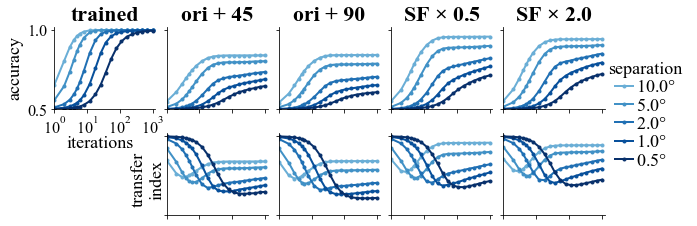

In [10]:
diff_cm = plt.get_cmap('plasma')

title_dict = dict(train='trained',angle='angle + 90',wave = 'wavelength x 2')
ylabel_dict  = dict(accs='acc', dps='d\'', n_accs='unbiased acc', n_dps='unbiased d\'')


fig, axes = plt.subplots(2,5, figsize = (10,3.5), sharex = False, sharey = True)
for mi, measure in enumerate(['accs']):
    for ti, transfer_feat in enumerate(['train','angle', 'wave']):
        
        axes[0,0].set_ylabel(ylabel_dict[measure], fontsize =18)
                   
        if ti == 0:
            conds = [0]
        elif ti == 1:
            conds = [0,1]
        elif ti == 2:
            conds = [1,0]
            
        for ci in conds:
            if ti == 0:
                ax = axes[0,0]
            elif ti == 1:
                ax = axes[0,ti*2-1+ci]
            else:
                ax = axes[0,ti*2-ci]
            
            hist_diff = diff_group[measure].apply(lambda x: np.array([perf[transfer_feat][ci].mean(1) for perf in x]))
            hist_diff = hist_diff.sort_index(ascending=False)
            iters_diff = diff_group['iters'].apply(lambda x: x.iloc[0])
            iters_diff = iters_diff.sort_index(ascending=False)

            count_diff = hist_diff.apply(lambda x: x.shape[0])
            meanhist_diff = hist_diff.apply(lambda x: x.mean(0))
            stdhist_diff = hist_diff.apply(lambda x: x.std(0))
            semhist_diff = stdhist_diff/count_diff.apply(lambda x: np.sqrt(x))

            for di in range(ndiff):

                ax.plot(iters_diff.iloc[di], meanhist_diff.iloc[di],  marker='o', markersize='3',
                            color = diff_colors[di], lw=2, label = str(diff_values[::-1][di]))
                ax.fill_between(iters_diff.iloc[di], meanhist_diff.iloc[di] + semhist_diff.iloc[di], 
                                meanhist_diff.iloc[di] - semhist_diff.iloc[di],
                            color = [v * 1. for v in diff_colors[di]], lw=0, alpha = 0.5)
                #ax.set_xlim([0.5,transfer_diff_angle.shape[0]+.5])
            ax.set_ylim([0.5,1.02])
            ax.tick_params(labelsize=16)
            ax.set_xlim([1, 1200])
            #ax.grid(True)
            cool_spines(ax)
            ax.set_yticks(np.arange(0.5,1.02,0.5))

            ax.set_xscale('log')
            ax.set_xticks(np.logspace(0,3,4))
            ax.set_xticklabels([])


for mi, measure in enumerate(['accs']):
    for ti, transfer_feat in enumerate(['angle', 'wave']):
        
        axes[1,0].set_ylabel(ylabel_dict[measure], fontsize =18)
                   
        if ti == 0:
            conds = [0,1]
        elif ti == 1:
            conds = [1,0]
            
        for ci in conds:
            
            if ti == 0:
                ax = axes[1,ci+1]
            elif ti == 1:
                ax = axes[1,4-ci]
            
            hist_diff = diff_group[measure].apply(lambda x: np.array([(perf[transfer_feat][ci]/perf['train'][0]).mean(1) for perf in x]))
            hist_diff = hist_diff.sort_index(ascending=False)
            iters_diff = diff_group['iters'].apply(lambda x: x.iloc[0])
            iters_diff = iters_diff.sort_index(ascending=False)

            count_diff = hist_diff.apply(lambda x: x.shape[0])
            meanhist_diff = hist_diff.apply(lambda x: x.mean(0))
            stdhist_diff = hist_diff.apply(lambda x: x.std(0))
            semhist_diff = stdhist_diff/count_diff.apply(lambda x: np.sqrt(x))

            for di in range(ndiff):

                ax.plot(iters_diff.iloc[di], meanhist_diff.iloc[di],  marker='o', markersize='3',
                            color = diff_colors[di], lw=2, label = str(diff_values[::-1][di])+"$\degree$")
                ax.fill_between(iters_diff.iloc[di], meanhist_diff.iloc[di] + semhist_diff.iloc[di], 
                                meanhist_diff.iloc[di] - semhist_diff.iloc[di],
                            color = [v * 1. for v in diff_colors[di]], lw=0, alpha = 0.5)
                #ax.set_xlim([0.5,transfer_diff_angle.shape[0]+.5])
            ax.set_ylim([0.5,1.02])
            ax.tick_params(labelsize=16)
            ax.set_xlim([1, 1200])
            #ax.grid(True)
            cool_spines(ax)

            ax.set_xscale('log')
            ax.set_xticks(np.logspace(0,3,4))
            ax.set_xticklabels([])

axes[0,0].set_xscale('log')
axes[0,0].set_xticks(np.logspace(0,3,4))
axes[0,0].set_xticklabels(['$10^0$','$10^1$','$10^2$','$10^3$'],fontname='Times New Roman',fontsize=16)
                
fig.delaxes(axes[1,0])        
axes[0,0].set_title('trained', fontsize =22, weight='bold')
axes[0,1].set_title('ori + 45', fontsize =22, weight='bold')
axes[0,2].set_title('ori + 90', fontsize =22, weight='bold')
axes[0,3].set_title(r'SF $\times$ 0.5', fontsize =22, weight='bold')
axes[0,4].set_title(r'SF $\times$ 2.0', fontsize =22, weight='bold')
axes[0,0].text(0.12,-0.47,'iterations', fontsize=18, transform=axes[0,0].transAxes)
axes[0,0].xaxis.set_label_coords(0.5,-0.25)
axes[0,0].set_ylabel('accuracy', fontsize=18)
axes[1,1].text(-0.35,0.4,'transfer\nindex', fontsize=18, transform=axes[1,1].transAxes, 
               rotation=90,multialignment='center')

fig.tight_layout(rect=[0.015,0.03,0.895,1], w_pad=0, h_pad=-0.3)

leg = ax.legend(loc='center right', bbox_to_anchor=[1.0,0.5],ncol=1,bbox_transform=fig.transFigure, 
          title='separation', frameon=False, labelspacing=0.1, fontsize=18, handlelength=1, handletextpad=0.2)
leg.set_title("separation", prop = {'size':'large'})
plt.setp(leg.get_title(), multialignment='center')
#fig.savefig(fig_dir+'angle_perf_traj.svg')

[None, None]

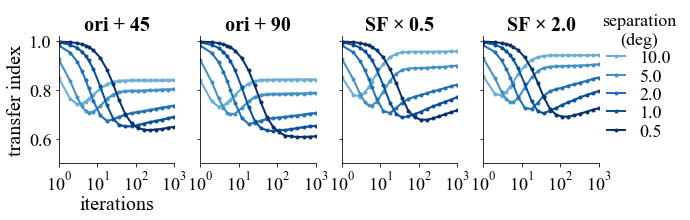

In [12]:
diff_cm = plt.get_cmap('plasma')

title_dict = dict(train='trained',angle='angle + 90',wave = 'wavelength x 2')
ylabel_dict  = dict(accs='acc', dps='d\'', n_accs='unbiased acc', n_dps='unbiased d\'')


fig, axes = plt.subplots(1,4, figsize = (10,3), sharex = True, sharey = True)
for mi, measure in enumerate(['accs']):
    for ti, transfer_feat in enumerate(['angle', 'wave']):
        
        axes[0].set_ylabel(ylabel_dict[measure], fontsize =18)
                   
        if ti == 0:
            conds = [0,1]
        elif ti == 1:
            conds = [1,0]
            
        for ci in conds:
            
            if ti == 0:
                ax = axes[ci]
            elif ti == 1:
                ax = axes[3-ci]
            
            hist_diff = diff_group[measure].apply(lambda x: np.array([(perf[transfer_feat][ci]/perf['train'][0]).mean(1) for perf in x]))
            hist_diff = hist_diff.sort_index(ascending=False)
            iters_diff = diff_group['iters'].apply(lambda x: x.iloc[0])
            iters_diff = iters_diff.sort_index(ascending=False)

            count_diff = hist_diff.apply(lambda x: x.shape[0])
            meanhist_diff = hist_diff.apply(lambda x: x.mean(0))
            stdhist_diff = hist_diff.apply(lambda x: x.std(0))
            semhist_diff = stdhist_diff/count_diff.apply(lambda x: np.sqrt(x))

            for di in range(ndiff):

                ax.plot(iters_diff.iloc[di], meanhist_diff.iloc[di],  marker='o', markersize='3',
                            color = diff_colors[di], lw=2, label = str(diff_values[::-1][di]))
                ax.fill_between(iters_diff.iloc[di], meanhist_diff.iloc[di] + semhist_diff.iloc[di], 
                                meanhist_diff.iloc[di] - semhist_diff.iloc[di],
                            color = [v * 1. for v in diff_colors[di]], lw=0, alpha = 0.5)
                #ax.set_xlim([0.5,transfer_diff_angle.shape[0]+.5])
            ax.set_ylim([0.5,1.02])
            ax.tick_params(labelsize=18)
            ax.set_xlim([1, 1000])
            #ax.grid(True)
            cool_spines(ax)
            #ax.set_yticks(np.arange(0.5,1.02,0.1))
            if ax.get_xlim()[1]!=1000:
                ax.set_xticks([1,25])
            else:
                ax.set_xscale('log')
                ax.set_xticks(np.logspace(0,3,4))
                ax.set_xticklabels(['$10^0$','$10^1$','$10^2$','$10^3$'],fontname='Times New Roman',fontsize=18)



axes[0].set_title('ori + 45', fontsize =20, weight='bold')
axes[1].set_title('ori + 90', fontsize =20, weight='bold')
axes[2].set_title(r'SF $\times$ 0.5', fontsize =20, weight='bold')
axes[3].set_title(r'SF $\times$ 2.0', fontsize =20, weight='bold')
axes[0].set_xlabel('iterations', fontsize=20)
axes[0].xaxis.set_label_coords(0.5,-0.25)
axes[0].set_ylabel('transfer index', fontsize=20)

fig.tight_layout(rect=[0.015,-0.1,0.9,1], w_pad=0.05)

leg = ax.legend(loc='center right', bbox_to_anchor=[0.99,0.65],ncol=1,bbox_transform=fig.transFigure, 
          title='separation', frameon=False, labelspacing=0.1, fontsize=18, handlelength=1)
leg.set_title("separation\n(deg)", prop = {'size':'large'})
plt.setp(leg.get_title(), multialignment='center')
#fig.savefig(fig_dir+'fig_2-2.tiff', dpi=300)

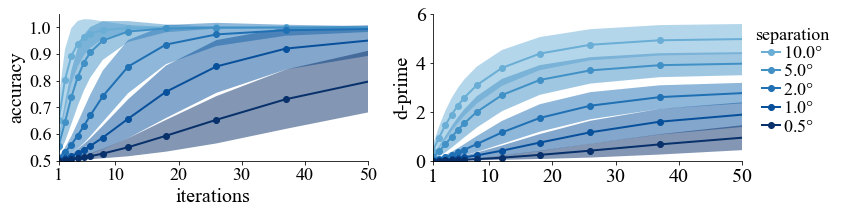

In [13]:
diff_cm = plt.get_cmap('plasma')

title_dict = dict(train='trained',angle='angle + 90',wave = 'wavelength x 2')
ylabel_dict  = dict(accs='acc', dps='d\'', n_accs='unbiased acc', n_dps='unbiased d\'')


fig, axes = plt.subplots(1,2, figsize = (12,3), sharex = True)
for mi, measure in enumerate(['accs']):
    for ti, transfer_feat in enumerate(['train']):
        ax = axes[0]
        
        axes[0].set_ylabel(ylabel_dict[measure], fontsize =15)
            
        hist_diff = diff_group[measure].apply(lambda x: np.array([perf[transfer_feat][0].mean(1) for perf in x]))
        hist_diff = hist_diff.sort_index(ascending=False)
        iters_diff = diff_group['iters'].apply(lambda x: x.iloc[0])
        iters_diff = iters_diff.sort_index(ascending=False)

        count_diff = hist_diff.apply(lambda x: x.shape[0])
        meanhist_diff = hist_diff.apply(lambda x: x.mean(0))
        stdhist_diff = hist_diff.apply(lambda x: x.std(0))
        semhist_diff = stdhist_diff/count_diff.apply(lambda x: np.sqrt(x))

        for di in range(ndiff):

            ax.plot(iters_diff.iloc[di], meanhist_diff.iloc[di],  marker='o',
                        color = diff_colors[di], lw=2, label = str(diff_values[::-1][di]))
            ax.fill_between(iters_diff.iloc[di], meanhist_diff.iloc[di] + stdhist_diff.iloc[di], 
                            meanhist_diff.iloc[di] - stdhist_diff.iloc[di],
                        color = [v * 1. for v in diff_colors[di]], lw=0, alpha = 0.5)
            #ax.set_xlim([0.5,transfer_diff_angle.shape[0]+.5])
        ax.set_ylim([0.5,1.05])
        ax.tick_params(labelsize=18)
        ax.set_xlim([1, 25])
        #ax.grid(True)
        cool_spines(ax)
        ax.set_yticks(np.arange(0.5,1.02,0.1))
        ax.set_xticks([1,100])
        
        # d-prime

        ax = axes[1]
        
        hist_diff = diff_group[measure].apply(lambda x: np.array([perf[transfer_feat][0].mean(1) for perf in x]))
        hist_diff = hist_diff.sort_index(ascending=False)
        iters_diff = diff_group['iters'].apply(lambda x: x.iloc[0])
        iters_diff = iters_diff.sort_index(ascending=False)

        count_diff = hist_diff.apply(lambda x: x.shape[0])
        meanhist_diff = hist_diff.apply(lambda x: norm.ppf(x).mean(0))
        stdhist_diff = hist_diff.apply(lambda x:  norm.ppf(x).std(0))
        semhist_diff = stdhist_diff/count_diff.apply(lambda x: np.sqrt(x))

        for di in range(ndiff):

            ax.plot(iters_diff.iloc[di], meanhist_diff.iloc[di],  marker='o',
                        color = diff_colors[di], lw=2, label = str(diff_values[::-1][di])+"$\degree$")
            ax.fill_between(iters_diff.iloc[di], meanhist_diff.iloc[di] + stdhist_diff.iloc[di], 
                            meanhist_diff.iloc[di] - stdhist_diff.iloc[di],
                        color = [v * 1. for v in diff_colors[di]], lw=0, alpha = 0.5)
            #ax.set_xlim([0.5,transfer_diff_angle.shape[0]+.5])
        ax.set_ylim([0,6])
        ax.tick_params(labelsize=20)
        ax.set_xlim([1, 50])
        #ax.grid(True)
        cool_spines(ax)
        ax.set_xticks([1,10,20,30,40,50])


axes[0].set_xlabel('iterations', fontsize=20)
axes[0].set_ylabel('accuracy', fontsize=20)
axes[1].set_ylabel('d-prime', fontsize=20)

fig.tight_layout(rect=[0,-0.08,0.9,1])

leg = ax.legend(loc='center right', bbox_to_anchor=[0.99,0.58],ncol=1,bbox_transform=fig.transFigure, 
          title='separation', frameon=False, labelspacing=0.1, fontsize=18, handlelength=1, handletextpad=0.2)
leg.set_title("separation", prop = {'size':'large'})
plt.setp(leg.get_title(), multialignment='center')
fig.savefig(fig_dir+'fig_2-1.svg', dpi=300)
fig.savefig(fig_dir+'fig_2-1.tiff', dpi=300)

In [14]:
this_df = df[['n_accs','accs',diff_var, 'angle', 'wave','ctrst','noise']].copy()
this_df['measure'] = this_df.apply(lambda x: x['accs']['angle'][1][-1].mean(), axis=1)*1

model = ols('measure ~ np.log10(d_angle)', data = this_df).fit()
print model.summary()
print model.pvalues
print sm.stats.anova_lm(model)

                            OLS Regression Results                            
Dep. Variable:                measure   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     1195.
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          2.23e-219
Time:                        23:06:00   Log-Likelihood:                 1716.8
No. Observations:                2880   AIC:                            -3430.
Df Residuals:                    2878   BIC:                            -3418.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6566      0.00

C:\Anaconda64\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda64\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda64\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## Supp: all details

C:\Anaconda64\lib\site-packages\ipykernel\__main__.py:24: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


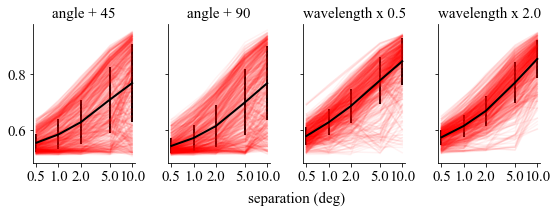

In [15]:
title_dict = dict(angle='angle + 45',wave = 'wavelength x 0.5')
ylabel_dict  = dict(accs='acc', n_accs='unbiased acc')
measures = ['accs']

fig, axes = plt.subplots(1,4, figsize = (8,3), sharex = True, sharey = True)
if axes.ndim == 1:
    axes = axes[None,:]

conds = [0,1]
for mi, measure in enumerate(measures):
    for ti, transfer_feat in enumerate(['angle', 'wave']):
                
        for ci in conds:
            ax = axes[0, ti*2+ci]
            #build small dataframe
            this_df = df[[diff_var, 'angle', 'wave', 'ctrst', 'noise', measure]].copy()
            this_df['measure'] = this_df.apply(lambda x: x[measure][transfer_feat][ci].mean(), axis=1)
            this_df.drop(measure,axis=1,inplace=True)
            this_df = this_df.sort_values(diff_var)

            # plot with grouping
            this_df.groupby(['angle','wave','ctrst','noise']).apply(lambda x: 
                        ax.plot(x[diff_var], x['measure'], 'r', alpha = 0.05));
            this_df.groupby(diff_var)['measure'].agg(dict(mean=np.mean, sem=np.std)).plot(
                        ax = ax, yerr='sem', color ='k', lw=2, legend=None)
            ndata = this_df.groupby(diff_var).size().unique()[0]
            ax.set_xlim([diff_values.min()*0.9,1.1*diff_values.max()])
            ax.set_xscale('log')
            ax.set_xlabel('')
            cool_spines(ax)
            ax.minorticks_off()
            ax_xticks(ax, diff_values, diff_values)
            
axes[0,0].set_title('angle + 45')
axes[0,1].set_title('angle + 90')
axes[0,2].set_title('wavelength x 0.5')
axes[0,3].set_title('wavelength x 2.0')            

fig.tight_layout(rect=[0,0.03,1,1])
fig.text(0.53, 0.02, 'separation (deg)', ha='center')
#fig.savefig(fig_dir + 'supp/detailed_transfer_perform.pdf')

## main: without detailed individual lines

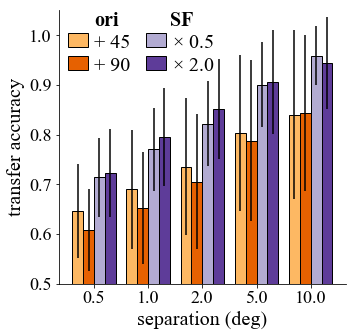

In [16]:
title_dict = dict(angle='angle + 45',wave = 'wavelength x 0.5')
ylabel_dict  = dict(accs='acc', n_accs='unbiased acc')
measures = ['accs']
nmeasure = len(measures)
fig, axes = plt.subplots(1,len(measures), figsize = (5,4.7), sharey = True)

if nmeasure == 1:
    ax = axes
cond_names = ['+ 45', '+ 90', r'$\times$ 0.5', r'$\times$ 2.0']
cond_colors = [
    '#fdb863',
    '#e66101',
    '#b2abd2',
    '#5e3c99']
for mi, measure in enumerate(measures):
    if nmeasure>1:
        ax = axes[mi]
    this_df = df[[diff_var, 'angle', 'wave', 'ctrst', 'noise', measure]].copy()
    #this_df = this_df.query('wave==10')
    for ti, transfer_feat in enumerate(['angle', 'wave']):
        if ti == 0:
            conds = [0,1]
        elif ti == 1:
            conds = [1,0]
        for cii, ci in enumerate(conds):
            this_df[cond_names[ti*2+cii]] = this_df.apply(lambda x: x[measure][transfer_feat][ci][-1].mean(), axis=1)
            this_df = this_df.sort_values(diff_var)

    mean_df = this_df.groupby(diff_var)[cond_names].apply(np.mean)
    err_df = this_df.groupby(diff_var)[cond_names].apply(lambda x: np.std(x))

    mean_df.plot.bar(ax = ax, yerr=err_df.values.T, legend=None, color = cond_colors, width = 0.8, rot = 0,
                    edgecolor='k')
    ndata = this_df.groupby(diff_var).size().unique()[0]
    #ax.set_xlim([diff_values.min()*0.9,1.1*diff_values.max()])
    #ax.set_xscale('log')
    ax.set_xlabel('')
    cool_spines(ax)
    ax.minorticks_off()
    ax.set_ylim([0.5,1.05])
    #ax.grid('on', axis='y')
    
    ax_xticks(ax, range(5), ['0.5', '1.0','2.0', '5.0', '10.0'])
    ax.set_yticks(np.arange(0.5,1.02,0.1))
    ax.set_yticklabels(np.arange(0.5,1.1,0.1))


ax.set_xlabel('separation (deg)', fontsize = 20)
ax.set_ylabel('transfer accuracy', fontsize =20)

ax.tick_params(labelsize=18)
leg = ax.legend(cond_names, loc='upper center', bbox_to_anchor=[0.38,0.93],ncol=2,
                handletextpad=0.3, fontsize=20, frameon=False,
                handlelength=1,bbox_transform=fig.transFigure, columnspacing=0.8, labelspacing=0.25)
ax.text(0.0,1.02, 'ori', fontsize=20, weight='bold')
ax.text(1.4,1.02, 'SF', fontsize=20, weight='bold')
fig.tight_layout(rect = [-0.04,-0.05,1.0,1.0])

#fig.savefig(fig_dir+'final_transfer_acc.svg')

In [17]:
ori_store = pd.HDFStore('results/test_all_ang_2.h5','r')
wave_store = pd.HDFStore('results/test_all_wave_2.h5','r')
ori_transfer_feats = [0.0,45.0,90.0]
wave_transfer_feats = [1.0,2.0,0.5]

ori_diff_values = np.sort(ori_store['accs/0.0']['d_angle'].unique())
wave_diff_values = np.sort(wave_store['accs/1.0']['d_angle'].unique())
ndiff = len(wave_diff_values)

In [18]:
this_df = ori_store['/'.join(['accs','45.0'])]
#this_df = this_df.query('ctrst==0.3 and wave == 10.0 and noise == 10')

acc_mean = this_df.groupby(['d_angle']).apply(lambda x: x.mean(0))[ori_diff_values]

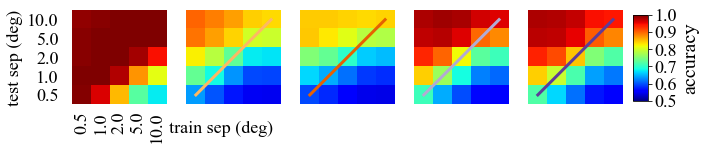

In [19]:
fig, axes = plt.subplots(1,5,figsize=(10,2.4), sharey=True)
axes[0].set_ylabel('acc')
#axes[1,0].set_ylabel('unbiased acc')
titles = ['trained', 'angle + 45', r'angle + 90',r'SF $\times$ 0.5', r'SF $\times$ 2.0']
for ti, tf in enumerate(ori_transfer_feats):
    #axes[ti].set_title(titles[ti], fontsize=18)
    for mi, measure in enumerate(['accs']):
        ax = axes[ti]
        this_df = ori_store['/'.join([measure,str(tf)])]
        #this_df = this_df.query('ctrst==0.3 and wave == 10.0 and noise == 10')

        acc_mean = this_df.groupby(['d_angle']).apply(lambda x: x.mean(0))[ori_diff_values]
        acc_sem = this_df.groupby(['d_angle']).apply(lambda x: x.std(0)/np.sqrt(len(x)))[ori_diff_values]

        cax = ax.imshow(acc_mean.values.T[::-1], vmin = 0.5, vmax = 1.0, cmap='jet', aspect='equal')
        ax.tick_params(reset = False, which = u'both', direction='out')

        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        


        map(lambda s: s.set_visible(False), ax.spines.values())
        
for ti, tf in enumerate(wave_transfer_feats[1:]):
    #axes[ti+3].set_title(titles[ti+3], fontsize=18)
    for mi, measure in enumerate(['accs']):
        ax = axes[ti+3]

        this_df = wave_store['/'.join([measure,str(tf)])]
        #this_df = this_df.query('ctrst==0.3 and wave == 10.0 and noise == 10')

        acc_mean = this_df.groupby(['d_angle']).apply(lambda x: x.mean(0))[wave_diff_values]
        acc_sem = this_df.groupby(['d_angle']).apply(lambda x: x.std(0)/np.sqrt(len(x)))[wave_diff_values]

        cax = ax.imshow(acc_mean.values.T[::-1], vmin = 0.5, vmax = 1.0, cmap='jet')
        ax.tick_params(reset = False, which = u'both', direction='out')

        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        #ax.set_xticklabels([])

        map(lambda s: s.set_visible(False), ax.spines.values())

for ai, ax in enumerate(axes[1:]):
    ax.plot([0,4.0],[4,0], lw=3, ls='-', color=cond_colors[ai])   
ax = axes[0]
ax.set_ylabel('test sep (deg)', fontsize = 18)
fig.tight_layout(rect=[0.04,0.3,0.88,1], pad=0.1)

for i in range(4):
    axes[i+1].set_xticklabels([])

ax.tick_params(labelsize=9)

ax_yticks(ax, range(ndiff), ori_diff_values[::-1], fontsize=18)
ax_xticks(ax, range(ndiff), ori_diff_values, rotation = 90, fontsize = 18)

#ax.set_aspect('equal')
#ax.axis('equal',adjustable='box')

cbar_ax = fig.add_axes([0.88, 0.452, 0.02, 0.5])
fig.colorbar(cax, cax=cbar_ax, ticks = np.linspace(0.5,1.0,6))
cbar_ax.set_ylabel('accuracy', fontsize=20)
cbar_ax.set_yticklabels(np.linspace(0.5,1.0,6), fontsize=18)
axes[1].text(-0.1,-0.3,'train sep (deg)', fontsize = 18, transform=axes[1].transAxes)
    
for i in range(5):
    #axes[i].set_xlim([-0.5,4.5])
    #axes[i].set_ylim([4.5,-0.5])
    axes[i].set_aspect('equal')
#fig.savefig(fig_dir+'train_test_sep.svg', dpi = 300)

In [20]:
this_df = ori_store['/'.join(['accs','45.0'])]
accs_df_melt = pd.melt(this_df, id_vars=['noise', 'angle', 'wave', 'ctrst','d_angle']
        , value_vars=ori_diff_values.tolist(), var_name = 'test_d_angle', value_name='acc')
accs_df_melt = accs_df_melt.astype(float)
def stats_test(x):
    model = ols('acc ~ np.log10(d_angle)  + np.log10(test_d_angle)', data = x).fit()
    print model.summary2()
    anova_res = sm.stats.anova_lm(model)
    print anova_res
    print anova_res['sum_sq']/sum(anova_res['sum_sq'])
    return model
model = stats_test(accs_df_melt[(accs_df_melt['wave']>0) & (accs_df_melt['ctrst']>0)])

                    Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.423      
Dependent Variable:  acc               AIC:                 -16997.9431
Date:                2018-03-12 23:07  BIC:                 -16975.2181
No. Observations:    14400             Log-Likelihood:      8502.0     
Df Model:            2                 F-statistic:         5290.      
Df Residuals:        14397             Prob (F-statistic):  0.00       
R-squared:           0.424             Scale:               0.017980   
-----------------------------------------------------------------------
                        Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               0.6882   0.0016 429.4159 0.0000  0.6850  0.6913
np.log10(d_angle)      -0.0863   0.0024 -36.0908 0.0000 -0.0910 -0.0816
np.log10(test_d_angle)  0.2302   0.0024  96.3165 0.0000  0.2256  0.2349
------------

In [21]:
this_df = wave_store['/'.join(['accs','0.5'])]
accs_df_melt = pd.melt(this_df, id_vars=['noise', 'angle', 'wave', 'ctrst','d_angle']
        , value_vars=ori_diff_values.tolist(), var_name = 'test_d_angle', value_name='acc')
accs_df_melt = accs_df_melt.astype(float)
def stats_test(x):
    model = ols('acc ~ np.log10(d_angle)  + np.log10(test_d_angle)', data = x).fit()
    print model.summary2()
    anova_res = sm.stats.anova_lm(model)
    print anova_res
    print anova_res['sum_sq']/sum(anova_res['sum_sq'])*100
stats_test(accs_df_melt[(accs_df_melt['wave']>0) & (accs_df_melt['ctrst']>0)])

                    Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.681      
Dependent Variable:  acc               AIC:                 -27487.3382
Date:                2018-03-12 23:07  BIC:                 -27464.6132
No. Observations:    14400             Log-Likelihood:      13747.     
Df Model:            2                 F-statistic:         1.539e+04  
Df Residuals:        14397             Prob (F-statistic):  0.00       
R-squared:           0.681             Scale:               0.0086783  
-----------------------------------------------------------------------
                        Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               0.7679   0.0011 689.7157 0.0000  0.7657  0.7701
np.log10(d_angle)      -0.1186   0.0017 -71.4108 0.0000 -0.1219 -0.1153
np.log10(test_d_angle)  0.2662   0.0017 160.2626 0.0000  0.2629  0.2694
------------

In [22]:
sg.Figure("18cm", "6.3cm",
       sg.Panel(
          sg.SVG(fig_dir+'angle_perf_traj.svg').move(0,0).scale(0.63),
          sg.Text("A", 15, 5, size=15, weight='bold').move(0,10),
          ),
       sg.Panel(
          sg.SVG(fig_dir+'train_test_sep.svg').scale(0.635),
          sg.Text("C", 15, 0, size=15, weight='bold').move(0,-5),
          ).move(0, 150),
       sg.Panel(
          sg.SVG(fig_dir+'final_transfer_acc.svg').move(0,0).scale(0.67),
          sg.Text("B", 15, 5, size=15, weight='bold').move(0,5),
          ).move(447,10)
).save(fig_dir+"fig_2.svg")

display(SVG(fig_dir+'fig_2.svg'))


## Supp: including multiple measures

# Layer change
## main

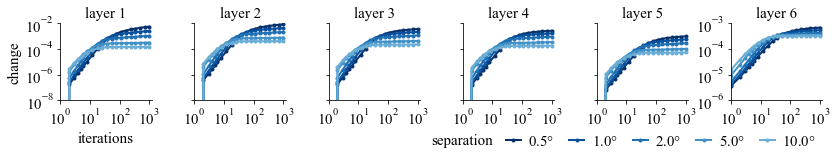

In [23]:
dw_measures = ['rel_1norm']
nmeasure = len(dw_measures)
fig, axes = plt.subplots(1,nlayer, figsize = (12,2.5*nmeasure), sharex = True)
axes = axes[None,:]
for mi, measure in enumerate(dw_measures):
    for li, ln in enumerate(layer_names):
        ax = axes[0, li]
        this_df = df[['dws', diff_var]].copy()
        this_df[iters] = df['dws'].apply(lambda x: pd.Series(x[ln][measure], index=iters))
        this_df.drop('dws',axis=1, inplace=True)
        
        if ln == 'vpl':
            this_df[iters] /= 9216
        
        mean_df = this_df.groupby(diff_var).mean()
        err_df = this_df.groupby(diff_var).sem()
        iters = mean_df.columns.values.astype('float')
        for di in range(ndiff):

            ax.plot(iters, mean_df.iloc[di],  marker='o', markersize='3',
                        color = diff_colors[::-1][di], lw=2, label = str(diff_values[di])+"$\degree$")
            ax.fill_between(iters, mean_df.iloc[di] + err_df.iloc[di], 
                            mean_df.iloc[di] - err_df.iloc[di],
                        color = [v * 1. for v in diff_colors[di]], lw=0, alpha = 0.5)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xticks([1,10,100,1000])
        ax.set_xticklabels(['$10^{%d}$' %d for d in [0,1,2,3] ], fontsize=15)
        ax.set_xlim(1,1200)
        #ax.grid(True)
        cool_spines(ax)
        if mi == 0:
            ax.set_title('layer %d' % (li+1))
        #ax.set_yticks([])
        if ln != 'vpl':
            ax.set_ylim([1e-8,1e-2])
            ax.set_yticks([1e-8,1e-6,1e-4,1e-2])
        else:
            ax.set_ylim([1e-6,1e-3])
            ax.set_yticks([1e-6,1e-5,1e-4,1e-3])
        if ln not in ['vpl', 'conv1']:
            ax.set_yticklabels([])

axes[-1,0].set_xlabel('iterations', fontsize = 15)
axes[0,0].set_ylabel('change', fontsize = 15)

fig.tight_layout(rect=[0.01,0.05,1.0,1.0], w_pad = 0.01, h_pad = 0.5)
#fig.text(0.01,0.55,'B',fontsize=15, fontweight=3)
#fig.text(0.52, 0.03, 'iteration', ha='center')
leg = ax.legend(loc='lower right', bbox_to_anchor=[0.98,0.05],ncol=5,
                bbox_transform=fig.transFigure, handlelength=1, columnspacing=1,
               handletextpad=0.5)
fig.text(0.52,0.145,'separation')
#fig.savefig(fig_dir+'layer_change.svg')

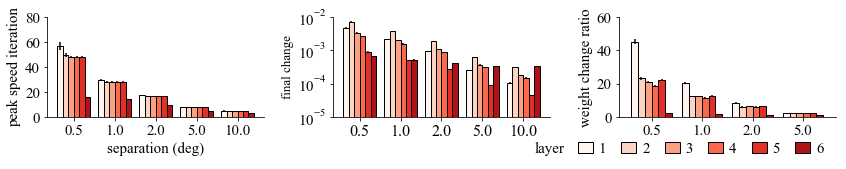

In [24]:
def layer_change_grad(w, iters):
    dw = w[1:]-w[:-1]
    dw = dw/(iters[1:]-iters[:-1])
    return dw
def find_v_peak(w, iters):
    funs = layer_change_grad(w, iters)
    spl = UnivariateSpline(iters[1:], np.array(funs), k=4, s=0)
    peaks = spl.derivative().roots()
    peak_vals = spl(peaks)
    return peaks[np.argmax(peak_vals)]

fig, axes = plt.subplots(1,3, figsize = (12,2.5*nmeasure))
if nmeasure == 1:
    axes = axes[None,:]

peak_df = this_df[['d_angle']]
for mi, measure in enumerate(dw_measures[:1]):
    ###############################
    this_df = df[['dws', diff_var]].copy()
    ax = axes[mi,0]
    for li, ln in enumerate(layer_names):

        this_df_layer= df['dws'].apply(lambda x: find_v_peak( x[ln][measure], iters+0.001))
        this_df[ln] = this_df_layer
        this_df_layer = pd.DataFrame(this_df_layer)

    this_df.drop('dws',axis=1, inplace=True)

    dw_mean = this_df.groupby(diff_var).median()
    dw_sem  = this_df.groupby(diff_var).sem()
    dw_mean[layer_names].plot.bar(yerr=dw_sem[layer_names].values.T, 
                                   ax = ax, color = layer_colors, legend=None, width = 0.8, rot = 0,
                                 edgecolor='k')
    
    cool_spines(ax)
    ax.minorticks_off()
    #ax.grid('on', axis='y')
    ax.set_xlabel('')
    ax.set_ylabel('peak speed iteration', fontsize=15)
    ax.set_xticklabels(diff_values, rotation = 0, fontsize = 15)
    ax.set_yticks(np.arange(0,81,20))
    ax.set_yticklabels(np.arange(0,81,20), fontsize=15)

    
    peak_df = this_df.copy()
    peak_df = pd.melt(peak_df, id_vars='d_angle', value_vars=layer_names, var_name = 'layer', value_name='peak')
    peak_df.replace(dict(zip(layer_names, range(1,7,1))), inplace=True)
    
    ###########################
    
    this_df = df[[diff_var, 'angle', 'wave', 'ctrst', 'dws', 'noise']].copy()
    dw_df = pd.DataFrame([[ r[l][measure][-1] for l in r] for r in this_df['dws']], columns=layer_names )
    this_df = pd.concat([this_df, dw_df], axis=1)
    this_df.drop('dws',inplace=True, axis = 1)
    
    # vpl was measured using norm without dividing by any number, so divide by the number of units at this layer
    this_df['vpl']/=9216
    ax = axes[mi,1]
    dw_mean = this_df.groupby(diff_var).median()
    dw_sem  = this_df.groupby(diff_var).sem()
    dw_mean[layer_names].plot.bar(yerr=dw_sem[layer_names].values.T, 
                                   ax = ax, color = layer_colors, legend=None, width = 0.8, rot = 0,
                                 edgecolor='k', zorder=1)
    #ax.grid(True, axis='y') 
    ax.set_xlabel('')
    ax.set_ylabel('final change', fontsize=13)
    ax.set_yscale('log')
    #ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    cool_spines(ax)
    ax.set_ylim([1e-5,1e-2])
    ax.set_xticklabels(diff_values, fontsize=16)
    ax.set_yticks(np.logspace(-5,-2,4))
    ax.set_yticklabels([r'$10^{%d}$' % (i) for i in range(-5,-1,1)], 
                       fontsize=15)
    ax.set_axisbelow(True)
    ax.minorticks_off()
    change_df = pd.melt(this_df, id_vars=['d_angle',], value_vars=layer_names, var_name='layer', value_name='dw')
    change_df.replace(dict(zip(layer_names, range(1,7,1))), inplace=True)
    
    #########################
    # ratio toward the easiest run for each orientatio, assuming easies is in the first row of each group
    ax = axes[mi,2]
    easy_ratio = pd.concat([this_df[[diff_var]], 
          this_df[layer_names]/this_df.groupby(['angle', 'wave', 'ctrst']).transform('first')[layer_names]], 
           axis=1)
    easy_ratio = easy_ratio.query('d_angle<10')
    easy_ratio_mean = easy_ratio.groupby(diff_var).median()
    easy_ratio_sem  = easy_ratio.groupby(diff_var).sem()
    easy_ratio_mean.plot.bar(yerr=easy_ratio_sem.values.T, 
                             ax = ax, color = layer_colors, legend=None, width = 0.8, rot = 0,edgecolor='k')
    #ax.set_yscale('log')
    #ax.grid(True, axis='y')
    ax.set_xlabel('')
    cool_spines(ax)
    ax.set_ylim([1,60])
    ax.set_ylabel('weight change ratio', fontsize=15)
    ax.set_yticks(np.arange(0,70,20))
    ax.set_yticklabels(np.arange(0,70,20), fontsize=15)
    ax.set_xticklabels(diff_values, fontsize=15)
    

axes[0,0].set_xlabel('separation (deg)', fontsize = 15)
fig.tight_layout()
ax.legend(['%d' %d for d in range(1,7)], loc='lower right', bbox_to_anchor=[0.98,0.02],ncol=6,
                bbox_transform=fig.transFigure, handlelength=1, columnspacing=1,
               handletextpad=0.4)
fig.text(0.63,0.11,'layer')
#fig.savefig(fig_dir+'final_weights.tiff', dpi=300)
#fig.savefig(fig_dir+'layer_peak.svg')

In [25]:
sg.Figure("18cm", "7.2cm",
       sg.Panel(
          sg.SVG(fig_dir+'layer_change.svg').move(0,10).scale(0.79),
          sg.Text("A", 15, 5, size=15, weight='bold').move(0,10),
          ),
       sg.Panel(
          sg.SVG(fig_dir+'layer_peak.svg').scale(0.8),
          sg.Text("B", 15, 5, size=15, weight='bold'),
          sg.Text("C", 230,5, size=15, weight='bold'),
          sg.Text("D", 470, 5, size=15, weight='bold'),
          ).move(0, 140)
).save(fig_dir+"fig_3.svg")

display(SVG(fig_dir+'fig_3.svg'))

Linear regression to test if PSI depends on depends on difficulty.
* Found a dependence for angle difference = 0.5 and 1.0

In [26]:
model = ols('peak ~ layer', data = peak_df.query('d_angle==1.0').query('layer <= 5')).fit()
print model.summary2()
anova_res = sm.stats.anova_lm(model)
print anova_res
print anova_res['sum_sq']/sum(anova_res['sum_sq'])

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.006     
Dependent Variable: peak             AIC:                20975.5329
Date:               2018-03-12 23:08 BIC:                20987.4640
No. Observations:   2880             Log-Likelihood:     -10486.   
Df Model:           1                F-statistic:        18.24     
Df Residuals:       2878             Prob (F-statistic): 2.01e-05  
R-squared:          0.006            Scale:              85.166    
---------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
---------------------------------------------------------------------
Intercept   32.0764     0.4033   79.5367   0.0000   31.2856   32.8672
layer       -0.5193     0.1216   -4.2707   0.0000   -0.7577   -0.2809
-------------------------------------------------------------------
Omnibus:             1362.493      Durbin-Watson:       

Linear regression to test if PSI depends on depends on layer at each difficulty.
* Found a dependence for angle difference = 0.5 and 1.0

In [27]:
model = ols('peak ~  np.log10(d_angle) * layer', data = peak_df.query('d_angle>0.0').query('layer != 6')).fit()
print model.summary2()
anova_res = sm.stats.anova_lm(model)
print model.pvalues
print anova_res['PR(>F)']['layer']
print anova_res
print anova_res['sum_sq']/sum(anova_res['sum_sq'])*100

                      Results: Ordinary least squares
Model:                 OLS                Adj. R-squared:       0.417      
Dependent Variable:    peak               AIC:                  128270.2674
Date:                  2018-03-12 23:08   BIC:                  128300.5674
No. Observations:      14400              Log-Likelihood:       -64131.    
Df Model:              3                  F-statistic:          3431.      
Df Residuals:          14396              Prob (F-statistic):   0.00       
R-squared:             0.417              Scale:                432.47     
---------------------------------------------------------------------------
                         Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
---------------------------------------------------------------------------
Intercept                42.8272   0.5025  85.2358 0.0000  41.8423  43.8121
np.log10(d_angle)       -46.0238   0.8695 -52.9337 0.0000 -47.7281 -44.3196
layer                    -2.0683  

Linear regression to test if log weights change depends on log angle separation and layer.
* Found better regression using log weights change than original weights change, implying an interaction of angle separation and layer on weights change

In [28]:
model = ols('(dw) ~ np.log10(d_angle) * (layer)', data = change_df.query('layer != 6')).fit()
print model.summary()
anova_res = sm.stats.anova_lm(model)
print anova_res
print anova_res['sum_sq']/sum(anova_res['sum_sq'])*100

                            OLS Regression Results                            
Dep. Variable:                     dw   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     5062.
Date:                Mon, 12 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:08:06   Log-Likelihood:                 71829.
No. Observations:               14400   AIC:                        -1.436e+05
Df Residuals:                   14396   BIC:                        -1.436e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# Compare angle to face

In [29]:
fig_type = "A_angle_layer_['angle', 'wave']_[0.0,5.0,1.0]_5_[*_20.0_0.5]_[*_0.0]_20_0.0001_0.9_0.0_0_1000_6"
#fig_type = "A_angle_layer_['angle', 'wave']_[0.0,7.0,1.0]_5_[*.0_20.0_0.7]_[*_0.0]_20_0.0001_0.9_0.0_0_1000_8"
df = load_df(['accs', 'n_accs', 'dps','n_dps', 'filename', 'dws','iters'], fig_type)
df = df[df['d_angle'].isin([0.5,1.0,2.0,5.0,10.0])]
angle_diff_values = np.sort(df['d_angle'].unique())

angle_df = df.reset_index()

fig_type = "A_morph_*_*_layer_[0.0,5.0,1.0]_5_0.5_20_0.0001_0_5000_6"
#fig_type = "A_morph_*_*_layer_[0.0,7.0,1.0]_5_0.7_20_0.0001_0_5000_8"

df = load_df(['accs', 'n_accs', 'dps', 'filename', 'dws','iters'], fig_type)
print len(df)
face_diff_values = np.sort(df['level'].unique())[::-1]
#df.level = 6-df.level
face_df = df
df.groupby(['level','dset','ctrst']).count()

360


accs  base_lr  batch_size  dps  dws  filename  iters  \
level dset ctrst                                                         
1     0    0.5       6        6           6    6    6         6      6   
      1    0.5       6        6           6    6    6         6      6   
      2    0.5       6        6           6    6    6         6      6   
      3    0.5       6        6           6    6    6         6      6   
      4    0.5       6        6           6    6    6         6      6   
      5    0.5       6        6           6    6    6         6      6   
      6    0.5       6        6           6    6    6         6      6   
      7    0.5       6        6           6    6    6         6      6   
      8    0.5       6        6           6    6    6         6      6   
      9    0.5       6        6           6    6    6         6      6   
      10   0.5       6        6           6    6    6         6      6   
      11   0.5       6        6           6    6    6         6      6   
2     0    0.5       6        6           6    6    6         6      6   
      1    0.5       6        6           6    6    6         6      6   
      2    0.5       6        6           6    6    6         6      6   
      3    0.5       6        6           6    6    6         6      6   
      4    0.5       6        6           6    6    6         6      6   
      5    0.5       6        6           6    6    6         6      6   
      6    0.5       6        6           6    6    6         6      6   
      7    0.5       6        6           6    6    6         6      6   
      8    0.5       6        6           6    6    6         6      6   
      9    0.5       6        6           6    6    6         6      6   
      10   0.5       6        6           6    6    6         6      6   
      11   0.5       6        6           6    6    6         6      6   
3     0    0.5       6        6           6    6    6         6      6   
      1    0.5       6        6           6    6    6         6      6   
      2    0.5       6        6           6    6    6         6      6   
      3    0.5       6        6           6    6    6         6      6   
      4    0.5       6        6           6    6    6         6      6   
      5    0.5       6        6           6    6    6         6      6   
      6    0.5       6        6           6    6    6         6      6   
      7    0.5       6        6           6    6    6         6      6   
      8    0.5       6        6           6    6    6         6      6   
      9    0.5       6        6           6    6    6         6      6   
      10   0.5       6        6           6    6    6         6      6   
      11   0.5       6        6           6    6    6         6      6   
4     0    0.5       6        6           6    6    6         6      6   
      1    0.5       6        6           6    6    6         6      6   
      2    0.5       6        6           6    6    6         6      6   
      3    0.5       6        6           6    6    6         6      6   
      4    0.5       6        6           6    6    6         6      6   
      5    0.5       6        6           6    6    6         6      6   
      6    0.5       6        6           6    6    6         6      6   
      7    0.5       6        6           6    6    6         6      6   
      8    0.5       6        6           6    6    6         6      6   
      9    0.5       6        6           6    6    6         6      6   
      10   0.5       6        6           6    6    6         6      6   
      11   0.5       6        6           6    6    6         6      6   
5     0    0.5       6        6           6    6    6         6      6   
      1    0.5       6        6           6    6    6         6      6   
      2    0.5       6        6           6    6    6         6      6   
      3    0.5       6        6           6    6    6         6      6   
      4    0.5       6

In [30]:
layer_cm = plt.get_cmap('Reds')
layer_names = df['dws'][0].keys()
nlayer = len(layer_names)
layer_colors = [layer_cm((0.0+i)/(0.+nlayer)) for i in range(nlayer)]

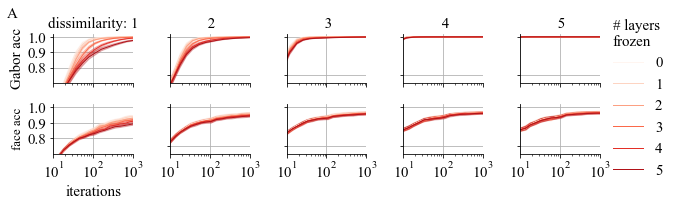

In [31]:
diff_cm = plt.get_cmap('Purples')   

transfer_feats = ['train', 'test']
diff_vars = ['d_angle', 'level']
diff_var_names = ['angle sep', 'face level']
diff_values = [angle_diff_values, face_diff_values]
measure = 'accs'

fig, axes = plt.subplots(2,5, figsize = (10,3), sharex = True)
for dfi, df in enumerate([angle_df, face_df]):
    
    diff_var = diff_vars[dfi]
    df.sort_values(diff_var, ascending=False, inplace=True)
    if dfi == 0:
        hist_df = df.groupby([diff_var,'start_layer']).apply(lambda x: np.array([perf[transfer_feats[dfi]][0].mean(1) for perf in x[measure]]) )
    else:
        hist_df = df.groupby([diff_var,'start_layer']).apply(lambda x: np.array([perf[transfer_feats[dfi]].mean(1) for perf in x[measure]]) )

    iter_df = df.groupby([diff_var,'start_layer']).apply(lambda x: x.iters.iloc[0] )

    meanhist_diff = hist_df.apply(lambda x: x.mean(0))
    semhist_diff = hist_df.apply(lambda x: sem(x,0))

    
    for di, diff in enumerate(diff_values[dfi]):
        
        ax = axes[dfi, di]
        axes[0, di].set_title(' %d' % (1+di))
        axes[0, 0].set_title('dissimilarity: 1')

        if di > 0:
            ax.set_yticklabels([])
        for si, start_layer in enumerate(layer_names):
            this_iter = iter_df[diff][si]
            this_mean = meanhist_diff[diff][si]
            this_sem = semhist_diff[diff][si]
            


            ax.errorbar(this_iter, this_mean, 
                        color = layer_colors[si], lw=1, label = si)
            ax.fill_between(this_iter, this_mean + this_sem, this_mean - this_sem, color = layer_colors[si], alpha = 0.3)
            #ax.set_xlim([0.5,transfer_diff_angle.shape[0]+.5])
        #ax.set_xlim([1, iter_df[diff][si].max()])
        ax.set_xscale('log')
        ax.grid(True)
        ax.set_ylim([0.7,1.02])
        ax.set_xlim([10,1000])
        if di == 0:
            ax_yticks(ax, np.arange(0.8,1.01,0.1), np.arange(0.8,1.01,0.1))
        #ax.set_yticks(np.arange(0.5,1.01,0.1))
        cool_spines(ax)

axes[1,0].set_ylabel('face acc', fontsize=13)
axes[0,0].set_ylabel('Gabor acc')
axes[1,0].set_xlabel('iterations')
fig.tight_layout(rect=[0,0.01,0.88,1.0])
ax.legend(loc='center right', bbox_to_anchor=[0.95,0.55],ncol=1,
          bbox_transform=fig.transFigure, title='# layers \nfrozen')
if nlayer == 6:
    fig.text(0.02,0.92,'A',**panel_font)

    #fig.savefig(fig_dir+'angle_face_traj.tiff', dpi=300)
else:
    fig.text(0.02,0.92,'D',**panel_font)
    #fig.savefig(fig_dir+'supp/angle_face_traj_8.tiff', dpi=300)

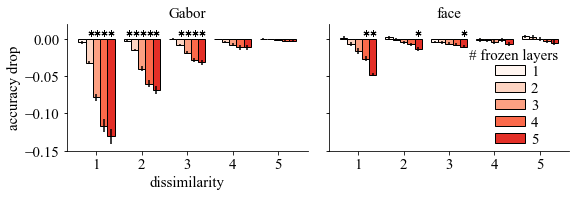

In [33]:
cri = 'accs'
cri_val = 0.95
rand_vars = ['angle','dset']

def compute_performance(this_df, diff_var, rand_var):

    if diff_var == 'level':
        perf_df = this_df.groupby([diff_var, rand_var]).apply(lambda x: pd.Series([np.interp(x['l0_tt'].iloc[0], 
                                                                        r[1]['iters'],
                                                                        r[1][cri]['test'].mean(1))
                                                                        for r in x.iterrows()]))
    else:
        perf_df = this_df.groupby([diff_var, rand_var]).apply(lambda x: pd.Series([np.interp(x['l0_tt'].iloc[0], 
                                                                        r[1]['iters'],
                                                                        r[1][cri]['train'][0].mean(1))
                                                                        for r in x.iterrows()]))
    perf_df.reset_index(inplace=True)

    perf_df = pd.melt(perf_df, id_vars = [diff_var, rand_var], var_name = 'start_layer', value_name='tt')
    return perf_df.astype('float')

fig, axes = plt.subplots(1,2,figsize=(8.3,3), sharey=True)
for dfi, df in enumerate([angle_df, face_df]):

    diff_var = diff_vars[dfi]
    rand_var = rand_vars[dfi]

    this_df = df[[cri, 'iters','start_layer', diff_var, rand_var]].copy().sort_values('start_layer')
    this_df.reset_index(inplace=True)
    
    this_df['l0_tt'] = 0
    
    if dfi == 0:
        this_df['l0_tt'] = this_df[this_df.start_layer == 0].apply(lambda x:  
                                                        np.interp(cri_val, 
                                                            x[cri]['train'][0].mean(1),
                                                            x['iters']
                                                                 ), axis=1)
    else:
        this_df['l0_tt'] = this_df[this_df.start_layer == 0].apply(lambda x:  
                                                        np.interp(cri_val, 
                                                            x[cri]['test'].mean(1),
                                                            x['iters']
                                                                 ), axis=1)
    #if dfi == 1:
    #    adf
    this_df = compute_performance(this_df, diff_var, rand_var)

    ax = axes[dfi]
    if dfi == 1:
        this_df['level'] = nlayer - this_df['level'] 
    this_df['tt_mult'] = this_df['tt'] - this_df.groupby([rand_var,diff_var]).transform('first')['tt']
    
    #for li, ln in enumerate():
    #    drops = this_df.groupby([diff_var])['tt_mult']
    this_df = this_df.query('start_layer != 0')
    test_df = this_df.groupby([diff_var,'start_layer'])['tt_mult'].apply(lambda x: ttest_1samp(x,0)[1])
    tt_mean = this_df.groupby([diff_var,'start_layer'])['tt_mult'].mean()
    tt_sem = this_df.groupby([diff_var,'start_layer'])['tt_mult'].sem()
    
    tt_mean = tt_mean.unstack(level=1)
    tt_sem = tt_sem.unstack(level=1)
    
    for di, dv in enumerate(tt_mean.index.values):
        for li, ln in enumerate(tt_mean.columns):
            if test_df.loc[dv, ln]<0.01/30:
                if nlayer == 6:
                    ax.plot(di - 0.28 + 0.15 *li, 0.008, marker=(6, 2, 0), color = 'k', label = None)
                else:
                    ax.plot(di - 0.33 + 0.11 *li, 0.01, '*', color = 'k', label = None, ms = 5)
    
    tt_mean.plot.bar(ax = ax, yerr = tt_sem.values.T, 
                          color = layer_colors, width=0.8, legend = None, ec='k')

    ax.set_xlabel('')
    cool_spines(ax)
    if nlayer==6:
        ax.set_ylim([-0.15,0.02])
    else:
        ax.set_ylim([-0.35,0.02])
    ax_xticks(ax, range(5), range(1,6), rotation=0)
    if dfi==0:
        angle_drop_df = this_df.copy()
    else:
        face_drop_df  = this_df.copy()
    
axes[0].set_ylabel('accuracy drop', fontsize=15)
axes[0].set_xlabel('dissimilarity', fontsize=15)
axes[0].set_title('Gabor', fontsize=15)
axes[1].set_title('face', fontsize=15)
fig.tight_layout(rect=[0,0.0,1.0,1])
leg = ax.legend(ax.patches[::5],range(1,8), loc='center right', bbox_to_anchor=[0.94,0.47],ncol=1,
                bbox_transform=fig.transFigure, handlelength=2, columnspacing=0.8, labelspacing=0.2,
               handletextpad=0.4)  
fig.text(0.8,0.68,'# frozen layers')

if nlayer == 6:
    pass
    #fig.savefig(fig_dir+'face_angle_acc_drop.svg')
else:
    fig.text(0.02,0.9,'E',fontsize = 22)
    #fig.savefig(fig_dir+'supp/face_angle_acc_drop_8.tiff', dpi=300)

In [34]:
for di, dv in enumerate(angle_diff_values):
    angle_drop_df['d_angle'][angle_drop_df['d_angle'] == dv] = 100 + di
angle_drop_df['d_angle'] = angle_drop_df['d_angle'] - 99

In [35]:
all_drop_df = angle_drop_df.rename(columns=dict(d_angle='level'))
all_drop_df['task']='angle'
face_drop_df['task']='face'
all_drop_df = pd.concat([all_drop_df, face_drop_df])

In [36]:
all_drop_df.shape

(600, 7)

In [38]:
model = ols('tt_mult ~ C(level) * C(start_layer)', data = face_drop_df).fit()
print model.summary()
print sm.stats.anova_lm(model)

                            OLS Regression Results                            
Dep. Variable:                tt_mult   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     18.89
Date:                Mon, 12 Mar 2018   Prob (F-statistic):           5.16e-45
Time:                        23:08:56   Log-Likelihood:                 1016.6
No. Observations:                 300   AIC:                            -1983.
Df Residuals:                     275   BIC:                            -1891.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [39]:
drop_data = angle_drop_df[['d_angle','start_layer','tt_mult']].values
cross_data = drop_data[:,0] * drop_data[:,1]
drop_data = np.c_[cross_data[:,None], drop_data]
r, pv, res = partial_corr(drop_data)
print r[0,-1], pv[0,-1]
res_df = pd.DataFrame(columns=['interact', 'drop', 'type'])
res_df = pd.concat([res_df, pd.DataFrame(dict(interact=res[0,-1,:,0], drop=res[0,-1,:,1], type='angle' ))])
res_df[['drop', 'interact']] = res_df[['drop', 'interact']].apply(lambda x: (x-x.mean())/x.std(), axis=0)

0.70684043554 1.02084497687e-46


In [40]:
drop_data = face_drop_df[['level','start_layer','tt_mult']].values
cross_data = drop_data[:,0] * drop_data[:,1]
drop_data = np.c_[cross_data[:,None], drop_data]
r, pv, res = partial_corr(drop_data)
print r[0,-1], pv[0,-1]
face_res_df=pd.DataFrame(dict(interact=res[0,-1,:,0], drop=res[0,-1,:,1], type='face' ))
face_res_df[['drop', 'interact']] = face_res_df[['drop', 'interact']].apply(lambda x: (x-x.mean())/x.std(), axis=0)
res_df=pd.concat([res_df, face_res_df])

0.406641701013 2.24805574312e-13


In [41]:
model = ols('drop ~ interact * type', data = res_df).fit()
print model.summary()
print model.pvalues
anova_res = sm.stats.anova_lm(model)
print anova_res
print anova_res['sum_sq']/sum(anova_res['sum_sq'])*100

                            OLS Regression Results                            
Dep. Variable:                   drop   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     98.96
Date:                Mon, 12 Mar 2018   Prob (F-statistic):           5.51e-52
Time:                        23:09:11   Log-Likelihood:                -729.10
No. Observations:                 600   AIC:                             1466.
Df Residuals:                     596   BIC:                             1484.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              5.551e-

In [42]:
layer_names = layer_names[:-1]

# Weights change distribution when freezing the first layer

In [43]:
fig_type = "A_angle_layer_['angle', 'wave']_[0.0,5.0,1.0]_5_[*_20.0_0.5]_[*_0.0]_20_0.0001_0.9_0.0_0_1000_6"
#fig_type = "A_angle_layer_['angle', 'wave']_[0.0,7.0,1.0]_5_[*.0_20.0_0.7]_[*_0.0]_20_0.0001_0.9_0.0_0_1000_8"
df = load_df(['accs', 'n_accs', 'dps','n_dps', 'filename', 'dws','iters'], fig_type)
df = df[df['d_angle'].isin([0.5,1.0,2.0,5.0,10.0])]
angle_df = df.reset_index()

fig_type = "A_morph_*_*_layer_[0.0,5.0,1.0]_5_0.5_20_0.0001_0_5000_6"
#fig_type = "A_morph_*_*_layer_[0.0,7.0,1.0]_5_0.7_20_0.0001_0_5000_8"

df = load_df(['accs', 'n_accs', 'dps', 'filename', 'dws','iters'], fig_type)
print len(df)
face_diff_values = np.sort(df['level'].unique())[::-1]
#df.level = 6-df.level
face_df = df
df.groupby(['level','dset','ctrst']).count()

360


accs  base_lr  batch_size  dps  dws  filename  iters  \
level dset ctrst                                                         
1     0    0.5       6        6           6    6    6         6      6   
      1    0.5       6        6           6    6    6         6      6   
      2    0.5       6        6           6    6    6         6      6   
      3    0.5       6        6           6    6    6         6      6   
      4    0.5       6        6           6    6    6         6      6   
      5    0.5       6        6           6    6    6         6      6   
      6    0.5       6        6           6    6    6         6      6   
      7    0.5       6        6           6    6    6         6      6   
      8    0.5       6        6           6    6    6         6      6   
      9    0.5       6        6           6    6    6         6      6   
      10   0.5       6        6           6    6    6         6      6   
      11   0.5       6        6           6    6    6         6      6   
2     0    0.5       6        6           6    6    6         6      6   
      1    0.5       6        6           6    6    6         6      6   
      2    0.5       6        6           6    6    6         6      6   
      3    0.5       6        6           6    6    6         6      6   
      4    0.5       6        6           6    6    6         6      6   
      5    0.5       6        6           6    6    6         6      6   
      6    0.5       6        6           6    6    6         6      6   
      7    0.5       6        6           6    6    6         6      6   
      8    0.5       6        6           6    6    6         6      6   
      9    0.5       6        6           6    6    6         6      6   
      10   0.5       6        6           6    6    6         6      6   
      11   0.5       6        6           6    6    6         6      6   
3     0    0.5       6        6           6    6    6         6      6   
      1    0.5       6        6           6    6    6         6      6   
      2    0.5       6        6           6    6    6         6      6   
      3    0.5       6        6           6    6    6         6      6   
      4    0.5       6        6           6    6    6         6      6   
      5    0.5       6        6           6    6    6         6      6   
      6    0.5       6        6           6    6    6         6      6   
      7    0.5       6        6           6    6    6         6      6   
      8    0.5       6        6           6    6    6         6      6   
      9    0.5       6        6           6    6    6         6      6   
      10   0.5       6        6           6    6    6         6      6   
      11   0.5       6        6           6    6    6         6      6   
4     0    0.5       6        6           6    6    6         6      6   
      1    0.5       6        6           6    6    6         6      6   
      2    0.5       6        6           6    6    6         6      6   
      3    0.5       6        6           6    6    6         6      6   
      4    0.5       6        6           6    6    6         6      6   
      5    0.5       6        6           6    6    6         6      6   
      6    0.5       6        6           6    6    6         6      6   
      7    0.5       6        6           6    6    6         6      6   
      8    0.5       6        6           6    6    6         6      6   
      9    0.5       6        6           6    6    6         6      6   
      10   0.5       6        6           6    6    6         6      6   
      11   0.5       6        6           6    6    6         6      6   
5     0    0.5       6        6           6    6    6         6      6   
      1    0.5       6        6           6    6    6         6      6   
      2    0.5       6        6           6    6    6         6      6   
      3    0.5       6        6           6    6    6         6      6   
      4    0.5       6

In [44]:
layer_cm = plt.get_cmap('Reds')
layer_names = df['dws'][0].keys()
nlayer = len(layer_names)
layer_colors = [layer_cm((0.0+i)/(0.+nlayer)) for i in range(nlayer)]
layer_names = layer_names[:-1]

In [45]:
layer_names

['conv1', 'conv2', 'conv3', 'conv4', 'conv5']

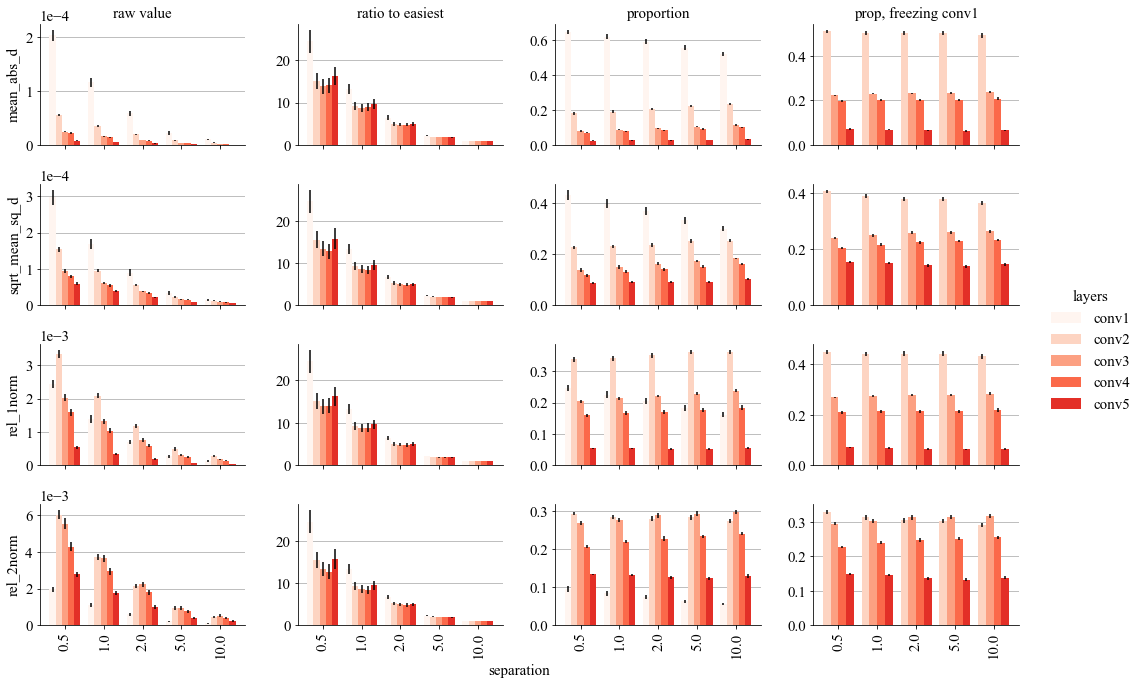

In [46]:
dw_measures = ['mean_abs_d', 'sqrt_mean_sq_d', 'rel_1norm','rel_2norm']
#dw_measures = ['rel_1norm', 'rel_2norm']
fig, axes = plt.subplots(4,4,figsize=(15,10), sharex = True)
prop_angle = dict()
prop_angle_freeze = dict()
df = angle_df
for mi, measure in enumerate(dw_measures):

    axes[0,0].set_title('raw value')
    axes[0,1].set_title('ratio to easiest')
    axes[0,2].set_title('proportion')
    axes[0,3].set_title('prop, freezing conv1')
    
    from_layer = 0
    this_df = df[df['start_layer']==from_layer].copy()
    this_df = this_df.reset_index()
    this_df = this_df[['angle','d_angle', 'wave', 'ctrst', 'dws', 'train_feat']].copy()
    
    dw_df = pd.DataFrame([[ r[l][measure][-1] for l in r.keys()[from_layer:-1]] for r in this_df['dws']], columns=layer_names )
    this_df = pd.concat([this_df, dw_df], axis=1)
    this_df.drop('dws',inplace=True, axis = 1)
    this_df.sort_values('d_angle', ascending=True, inplace=True)
    
    ax = axes[mi, 0]
    dw_mean = this_df.groupby('d_angle').mean()[layer_names]
    dw_sem  = this_df.groupby('d_angle').sem()[layer_names]
    dw_mean.plot.bar(yerr=dw_sem.values.T, 
                                   ax = ax, color = layer_colors, legend=None, width = 0.8)
    ax.set_xlabel('')
    # ax.set_yscale('log')
    ax.grid(True, axis='y') 
    ax.set_ylabel(measure)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    cool_spines(ax)

    # ratio toward the easiest run for each orientatio, assuming easies is in the first row of each group
    ax = axes[mi, 1]
    easy_ratio = pd.concat([this_df[['d_angle']], 
          this_df[layer_names]/this_df.groupby(['angle', 'wave', 'ctrst']).transform('last')[layer_names]], 
           axis=1)

    easy_ratio_mean = easy_ratio.groupby('d_angle').mean()[layer_names]
    easy_ratio_sem  = easy_ratio.groupby('d_angle').sem()[layer_names]
    easy_ratio_mean.plot.bar(yerr=easy_ratio_sem.values.T, 
                             ax = ax, color = layer_colors, legend=None, width = 0.8)
    ax.set_xlabel('')
    #ax.set_yscale('log')
    ax.grid(True, axis='y')
    cool_spines(ax)


    ax=axes[mi,2]
    mean_ratio = pd.concat([this_df[['d_angle']], 
                          this_df[layer_names].div(this_df[layer_names].sum(1),0)], axis=1)
    mean_ratio_mean = mean_ratio.groupby('d_angle').mean()
    mean_ratio_sem  = mean_ratio.groupby('d_angle').sem()
    mean_ratio_mean.plot.bar(yerr= mean_ratio_sem.values.T, 
                             ax = ax, color = layer_colors, legend=None, width = 0.8)
    prop_angle[measure] = mean_ratio[layer_names]
    #ax.set_xlabel('separation')
    ax.grid(True, axis='y')
    cool_spines(ax)
    ax.set_xlabel('')
    legend_ax = ax
    
    ax=axes[mi,3]
    this_df = df[df['start_layer']==1].copy()
    this_df = this_df.reset_index()
    this_df = this_df[['d_angle','ctrst', 'dws','angle', 'train_feat']]

    dw_df = pd.DataFrame([[ r[l][measure][-1] for l in r.keys()[1:-1]] for r in this_df['dws']], columns=layer_names[1:] )
    this_df = pd.concat([this_df, dw_df], axis=1)
    this_df.drop('dws',inplace=True, axis = 1)
    mean_ratio = pd.concat([this_df[['d_angle']], 
                          this_df[layer_names[1:]].div(this_df[layer_names[1:]].sum(1),0)], axis=1)
    mean_ratio_mean = mean_ratio.groupby('d_angle').mean()
    mean_ratio_sem  = mean_ratio.groupby('d_angle').sem()
    mean_ratio_mean.plot.bar(yerr= mean_ratio_sem.values.T, 
                             ax = ax, color = layer_colors[1:],  legend=None, width = 0.8)
    prop_angle_freeze[measure] = mean_ratio[layer_names[1:]]
    #ax.set_xlabel('separation')
    ax.grid(True, axis='y')
    cool_spines(ax)
    ax.set_xlabel('')
    
fig.tight_layout(rect=[0,0.05,0.98,1])
fig.text(0.5, 0.05, 'separation', ha='center')
legend_ax.legend(layer_names, loc='center left', bbox_to_anchor=[0.98,0.5],ncol=1,bbox_transform=fig.transFigure, title='layers')

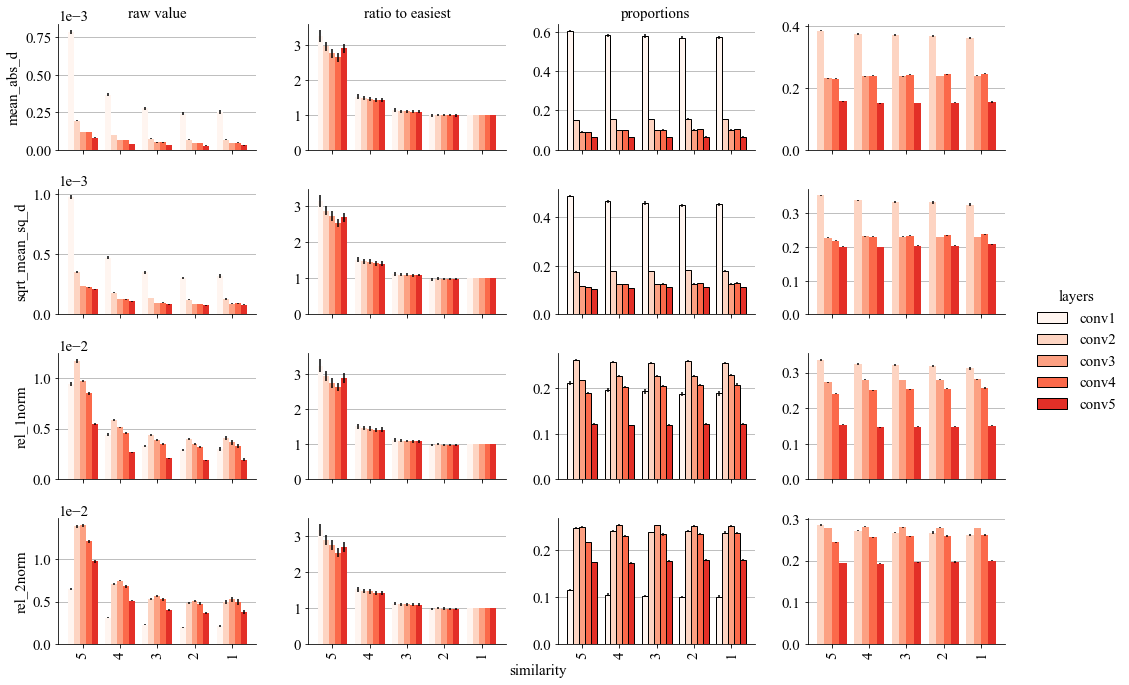

In [47]:
dw_measures = ['mean_abs_d', 'sqrt_mean_sq_d', 'rel_1norm','rel_2norm']
#dw_measures = ['rel_1norm','rel_2norm']

prop_morph = dict()
prop_morph_freeze = dict()

df = face_df
fig, axes = plt.subplots(4,4,figsize=(15,10), sharex = True)
for mi, measure in enumerate(dw_measures):
        
    axes[0,0].set_title('raw value')
    axes[0,1].set_title('ratio to easiest')
    axes[0,2].set_title('proportions ')

    this_df = df[df['start_layer']==0].copy()
    this_df = this_df.reset_index()
    this_df = this_df[['level','ctrst', 'dws','dset']]
    
    dw_df = pd.DataFrame([[ r[l][measure][-1] for l in r.keys()[from_layer:-1]] for r in this_df['dws']], columns=layer_names )
    this_df = pd.concat([this_df, dw_df], axis=1)
    this_df.drop('dws',inplace=True, axis = 1)
    this_df.sort_values('level', ascending=0, inplace=True)

    ax = axes[mi, 0]
    dw_mean = this_df.groupby('level').mean()
    dw_sem  = this_df.groupby('level').sem()
    dw_mean.sort_index(level='level', ascending=0, inplace=True)
    dw_sem.sort_index(level='level', ascending=0, inplace=True)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    cool_spines(ax)

    
    dw_mean[layer_names].plot.bar(yerr=dw_sem[layer_names].values.T, 
                                   ax = ax, color = layer_colors, legend=None, width = 0.8)
    ax.set_xlabel('')
    ax.grid(True, axis='y') 
    #ax.set_yscale('log')
    ax.set_ylabel(measure)

    # ratio toward the easiest run for each orientatio, assuming easies is in the first row of each group
    ax = axes[mi, 1]
    easy_ratio = pd.concat([this_df[['level']], 
          this_df[layer_names]/this_df.groupby(['ctrst', 'dset']).transform('last')[layer_names]], 
           axis=1)
    easy_ratio_mean = easy_ratio.groupby('level').mean()
    easy_ratio_sem  = easy_ratio.groupby('level').sem()
    easy_ratio_mean.sort_index(level='level', ascending=0, inplace=True)
    easy_ratio_sem.sort_index(level='level', ascending=0, inplace=True)
    easy_ratio_mean.plot.bar(yerr=easy_ratio_sem.values.T, 
                             ax = ax, color = layer_colors, legend=None, width = 0.8)
    ax.set_xlabel('')
    #ax.set_yscale('log')
    ax.grid(True, axis='y')
    cool_spines(ax)


    ax=axes[mi,2]
    mean_ratio = pd.concat([this_df[['level']], 
                          this_df[layer_names].div(this_df[layer_names].sum(1),0)], axis=1)
    mean_ratio_mean = mean_ratio.groupby('level').mean()
    mean_ratio_sem  = mean_ratio.groupby('level').sem()
    mean_ratio_mean.sort_index(level='level', ascending=0, inplace=True)
    mean_ratio_sem.sort_index(level='level', ascending=0, inplace=True)
    mean_ratio_mean.plot.bar(yerr= mean_ratio_sem.values.T, 
                             ax = ax, color = layer_colors, legend=None, width = 0.8, ec='k')
    prop_morph[measure] = mean_ratio[layer_names]
    ax.set_xlabel('')

    #ax.set_xlabel('separation')
    cool_spines(ax)
    ax.grid(True, axis='y')
    legend_ax = ax

    ax=axes[mi,3]
    #df = load_df(['accs', 'n_accs', 'dps', 'filename', 'dws','iters'], fig_type)
    this_df = df[df['start_layer']==1].copy()
    this_df = this_df.reset_index()    
    this_df = this_df[['level','ctrst', 'dws','dset']].copy()
    dw_df = pd.DataFrame([[ r[l][measure][-1] for l in r.keys()[1:-1]] for r in this_df['dws']], columns=layer_names[1:] )
    this_df = pd.concat([this_df, dw_df], axis=1)
    this_df.drop('dws',inplace=True, axis = 1)
    mean_ratio = pd.concat([this_df[['level']], 
                          this_df[layer_names[1:]].div(this_df[layer_names[1:]].sum(1),0)], axis=1)
    mean_ratio_mean = mean_ratio.groupby('level').mean().sort_index(level='level', ascending=0)
    mean_ratio_sem  = mean_ratio.groupby('level').sem().sort_index(level='level', ascending=0)
    mean_ratio_mean.plot.bar(yerr= mean_ratio_sem.values.T, 
                             ax = ax, color = layer_colors[1:], legend=None, width = 0.8)
    prop_morph_freeze[measure] = mean_ratio[layer_names[1:]]

    #ax.set_xlabel('separation')
    ax.grid(True, axis='y')
    cool_spines(ax)
    ax.set_xlabel('')
fig.tight_layout(rect=[0,0.05,0.95,1])
fig.text(0.5, 0.05, 'similarity', ha='center')
legend_ax.legend(layer_names, loc='center left', bbox_to_anchor=[0.95,0.5],ncol=1,bbox_transform=fig.transFigure, title='layers')

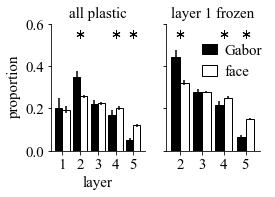

In [48]:
type_cm = plt.get_cmap('Greens')
ntype = 2
type_colors = ['k','w']

dw_measures = ['rel_1norm', 'rel_2norm','mean_abs_d', 'sqrt_mean_sq_d', ]


fig, axes = plt.subplots(1,2,figsize=(4,3), sharey = True)
for mi, measure in enumerate(['rel_1norm']):
    axes[0].set_title('all plastic')
    prop_angle_freeze[measure]['type'] = 'Gabor'
    prop_angle[measure]['type'] = 'Gabor'
    prop_morph_freeze[measure]['type'] = 'face'
    prop_morph[measure]['type'] = 'face'
    
    ax = axes[0]
    this_df = pd.concat([prop_angle[measure], prop_morph[measure]])
    prop_mean = this_df.groupby('type').mean().T
    prop_sem = this_df.groupby('type').std().T
    
    prop_mean.plot.bar(yerr=prop_sem, ax=ax, width=0.8, color = type_colors, legend=None, ec='k')
    for li, ln in enumerate(layer_names):
        Fv, pv = mannwhitneyu(prop_angle[measure][ln].values, prop_morph[measure][ln].values)
        if pv < 0.0001:
            ax.plot(li, [0.55], 'k', marker=(6, 2, 0), ms=8)
    cool_spines(ax)
    #ax.grid(True, axis='y')
    
    
    axes[1].set_title('layer 1 frozen', fontsize=15)
    ax = axes[1]
    this_df_freeze = pd.concat([prop_angle_freeze[measure], prop_morph_freeze[measure]])
    prop_mean = this_df_freeze.groupby('type').mean().T
    prop_sem = this_df_freeze.groupby('type').std().T
    
    prop_mean.plot.bar(yerr=prop_sem, ax=ax, width=0.8, color = type_colors, legend=None, ec='k')
    cool_spines(ax)
    for li, ln in enumerate(layer_names[1:]):
        Fv, pv = mannwhitneyu(prop_angle_freeze[measure][ln].values, prop_morph_freeze[measure][ln].values)
        if pv < 1e-2/5:
            ax.plot(li, [0.55], 'k', marker=(6, 2, 0), ms=8)
    cool_spines(ax)

    ax.set_ylim([0,0.6])
    #ax_yticks(ax, np.arange(0.0,0.7,0.2), np.arange(0.0,0.7,0.2))
    #ax.grid(True, axis='y')

axes[0].set_xlabel('layer', fontsize=15)
axes[0].set_ylabel('proportion', fontsize=15)
axes[1].set_xticklabels('')
ax_xticks(axes[0],range(nlayer-1), range(1,nlayer), rotation=0)    
ax_xticks(axes[1],range(nlayer-2), range(2,nlayer), rotation=0)    
fig.tight_layout(rect=[0.0,0.0,1,1])
ax.legend(loc='lower right', bbox_to_anchor=[0.99,0.53],ncol=1,bbox_transform=fig.transFigure, 
        columnspacing=0.8, handletextpad =0.5, prop={'size':15}, handlelength=1
         )
if nlayer == 6:
    pass
    #fig.savefig(fig_dir+'face_angl_prop.svg', dpi=300)
else:
    fig.text(0.01,0.9,'F',**panel_font)
    #fig.savefig(fig_dir+'supp/face_angl_prop_8.tiff', dpi=300)

In [49]:
this_df = pd.concat([prop_angle[measure], prop_morph[measure]])
melt_all_prop = pd.melt(this_df, id_vars='type', var_name='layer', value_name='p')
model = ols('p ~ C(layer) * C(type)', data
            = melt_all_prop).fit()
anova_res = sm.stats.anova_lm(model)
print anova_res
print anova_res['sum_sq']/sum(anova_res['sum_sq'])*100

print 'F(%d,%d)=%.2f\np=%.2g\nR2=%.2g' % (anova_res['df']['C(layer):C(type)'],
                                        anova_res['df']['Residual'],
                                        anova_res['F']['C(layer):C(type)'],
                                        anova_res['PR(>F)']['C(layer):C(type)'],
                                        anova_res['sum_sq']['C(layer):C(type)']/sum(anova_res['sum_sq']))

print 'F(%d,%d)=%.3g\np=%.2g\nR2=%.2g' % (anova_res['df']['C(type)'],
                                        anova_res['df']['Residual'],
                                        anova_res['F']['C(type)'],
                                        anova_res['PR(>F)']['C(type)'],
                                        anova_res['sum_sq']['C(type)']/sum(anova_res['sum_sq']))

                     df        sum_sq       mean_sq             F  \
C(layer)            4.0  2.940982e+00  7.352456e-01  1.803258e+03   
C(type)             1.0  1.524369e-32  1.524369e-32  3.738657e-29   
C(layer):C(type)    4.0  4.299977e-01  1.074994e-01  2.636524e+02   
Residual          590.0  2.405617e-01  4.077317e-04           NaN   

                         PR(>F)  
C(layer)           0.000000e+00  
C(type)            1.000000e+00  
C(layer):C(type)  8.748961e-130  
Residual                    NaN  
C(layer)            8.143288e+01
C(type)             4.220825e-31
C(layer):C(type)    1.190621e+01
Residual            6.660914e+00
Name: sum_sq, dtype: float64
F(4,590)=263.65
p=8.7e-130
R2=0.12
F(1,590)=3.74e-29
p=1
R2=4.2e-33


In [50]:
this_df = pd.concat([prop_angle_freeze[measure], prop_morph_freeze[measure]])
melt_all_prop = pd.melt(this_df, id_vars='type', value_vars=layer_names[1:], var_name='layer', value_name='p')
melt_all_prop.replace(dict(layer=dict(conv1=1, conv2=2, conv3=3, conv4=4, conv5=5)), inplace=True)
model = ols('p ~ C(layer) * C(type)', data
            = melt_all_prop).fit()
anova_res = sm.stats.anova_lm(model)
print 'F(%d,%d)=%.2f\np=%.2g\nR2=%.2g' % (anova_res['df']['C(layer):C(type)'],
                                        anova_res['df']['Residual'],
                                        anova_res['F']['C(layer):C(type)'],
                                        anova_res['PR(>F)']['C(layer):C(type)'],
                                        anova_res['sum_sq']['C(layer):C(type)']/sum(anova_res['sum_sq']))

print 'F(%d,%d)=%.3g\np=%.2g\nR2=%.2g' % (anova_res['df']['C(type)'],
                                        anova_res['df']['Residual'],
                                        anova_res['F']['C(type)'],
                                        anova_res['PR(>F)']['C(type)'],
                                        anova_res['sum_sq']['C(type)']/sum(anova_res['sum_sq']))

F(3,472)=908.80
p=1.2e-195
R2=0.13
F(1,472)=4.82e-32
p=1
R2=2.2e-36


In [51]:
sg.Figure("18cm", "4.3cm",
       sg.Panel(
          sg.SVG(fig_dir+'face_angle_acc_drop.svg').move(0,0).scale(0.8),
          sg.Text("A", 15, 5, size=15, weight='bold').move(0,10),
          ),
       sg.Panel(
          sg.SVG(fig_dir+'face_angl_prop.svg').move(0,-10).scale(0.8),
          sg.Text("B", 15, 5, size=15, weight='bold'),
          ).move(460, 10)
).save(fig_dir+"fig_5.svg")

display(SVG(fig_dir+'fig_5.svg'))

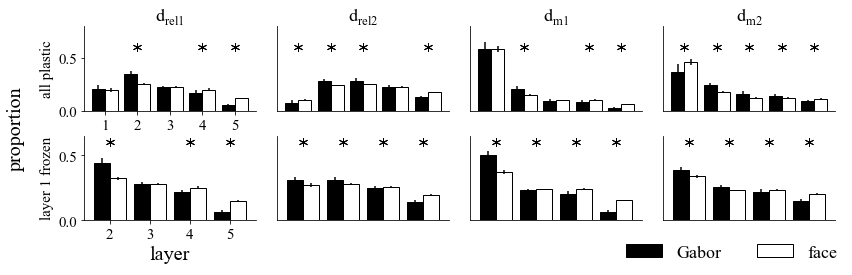

In [52]:
type_cm = plt.get_cmap('Greens')
ntype = 2
type_colors = ['k','w']
dw_measures = ['rel_1norm', 'rel_2norm','mean_abs_d', 'sqrt_mean_sq_d', ]
dw_equations = [r'$\frac{\Sigma_i |\delta w_i|}{\Sigma_i |w_i|}$', 
                r'$\frac{\sqrt{\Sigma_i |\delta w_i|^2}}{{\sqrt{\Sigma_i |w_i|^2}}}$',
               r'$\frac{\Sigma_i |\delta w_i|}{N}$', 
                r'$\frac{\sqrt{\Sigma_i |\delta w_i|^2}}{N}$', ]

dw_equations = [r'$d_{rel1}$', 
                r'$d_{rel2}$',
               r'$d_{m1}$', 
                r'$d_{m2}$', ]

fig, axes = plt.subplots(2,4,figsize=(12,3.8))
for mi, measure in enumerate(dw_measures):
    axes[0,0].set_ylabel('all plastic')
    prop_angle_freeze[measure]['type'] = 'Gabor'
    prop_angle[measure]['type'] = 'Gabor'
    prop_morph_freeze[measure]['type'] = 'face'
    prop_morph[measure]['type'] = 'face'
    
    ax = axes[0,mi]
    this_df = pd.concat([prop_angle[measure], prop_morph[measure]])
    prop_mean = this_df.groupby('type').mean().T
    prop_sem = this_df.groupby('type').std().T
    
    prop_mean.plot.bar(yerr=prop_sem, ax=ax, width=0.8, color = type_colors, legend=None, ec='k')
    for li, ln in enumerate(layer_names):
        Fv, pv = mannwhitneyu(prop_angle[measure][ln].values, prop_morph[measure][ln].values)
        if pv < 0.01/5:
            ax.plot(li, [0.6], 'k', marker=(6, 2, 0), ms=9)
    cool_spines(ax)
        
    ax.set_ylim([0,0.8])
    axes[1,0].set_ylabel('layer 1 frozen')
    ax = axes[1,mi]
    this_df = pd.concat([prop_angle_freeze[measure], prop_morph_freeze[measure]])
    prop_mean = this_df.groupby('type').mean().T
    prop_sem = this_df.groupby('type').std().T
    
    prop_mean.plot.bar(yerr=prop_sem, ax=ax, width=0.8, color = type_colors, legend=None, ec='k')
    cool_spines(ax)
    for li, ln in enumerate(layer_names[1:]):
        Fv, pv = mannwhitneyu(prop_angle_freeze[measure][ln].values, prop_morph_freeze[measure][ln].values)
        if pv < 1e-2/5:
            ax.plot(li, [0.6], 'k', marker = (6,2,0), ms=9)
    cool_spines(ax)


    if mi>0:
        axes[1,mi].set_xticks([]) 
        axes[0,mi].set_xticks([]) 
        axes[1,mi].set_yticks([]) 
        axes[0,mi].set_yticks([]) 

        
    axes[0,0].set_xticklabels(range(1,6), rotation=0)
    axes[1,0].set_xticklabels(range(2,6), rotation=0)
    

    #axes[0,mi].set_yticks([])
    ax.set_ylim([0,0.65])
    axes[0,mi].set_title(dw_equations[mi], fontsize=18)

fig.tight_layout(rect=[0.02,0.03,0.99,1.01], h_pad=0.05)
axes[1,0].set_xlabel('layer', fontsize=20)
ax.legend(loc='center right', bbox_to_anchor=[0.99,0.05],ncol=2,bbox_transform=fig.transFigure, prop={'size':18})
fig.text(0.01, 0.5, 'proportion', va='center', rotation=90, fontsize=20)
fig.savefig(fig_dir+'fig_5-1.svg', dpi=300)
fig.savefig(fig_dir+'fig_5-1.tiff', dpi=300)